# Import Libraries

In [42]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from choices import param_dict 
from utilities import deets

# Load data

In [128]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


## Loss Function

In [138]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
le = LabelEncoder()
X = x.copy()
y_label = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.20, random_state=42)

classes =[]
labeles=np.unique(y_label)
for v in labeles:
    classes.append('Class '+ str(v))
print(classes)

['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']


In [139]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score , recall_score , confusion_matrix , plot_confusion_matrix
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('Prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles)
#plot_confusion_matrix(cnf_matrix, labels=classes,normalize=True,  title='Confusion matrix')


Prediction accuracy 0.9279688513951979  recall  0.7581120165170178


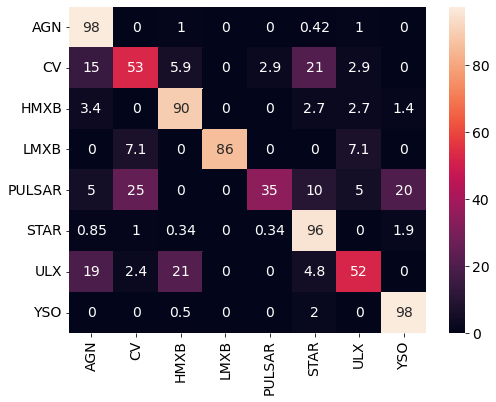

In [140]:
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles , normalize='true')
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(8,6))
l_name = le.inverse_transform(labeles)
sns.heatmap(cnf_matrix*100 , annot=True , xticklabels=l_name , yticklabels=l_name , ax=ax)
plt.show()

In [155]:
from OneVsRestLightGBMWithCustomizedLoss import *
from FocalLoss import FocalLoss #get the FocalLoss implementation from Halford's blog

# Instantiate Focal loss
loss = FocalLoss(alpha=0.05, gamma=0.5)

# Not using early stopping
clf = OneVsRestLightGBMWithCustomizedLoss(loss=loss)
#clf.fit(X_train, y_train)

# Using early stopping
fit_params = {
    'eval_set': [(X_test, y_test)] , 
    'fit_fit_params' :{
        'verbose' : 1
        } 
    }
clf.fit(X_train, y_train, **fit_params)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)


inside if
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9965
[LightGBM] [Info] Number of data points in the train set: 6162, number of used features: 41
[LightGBM] [Warning] Using self-defined objective function
[1]	fit's focal_loss: 0.0467146	val's focal_loss: 0.0478572
Training until validation scores don't improve for 10 rounds
[2]	fit's focal_loss: 0.0409485	val's focal_loss: 0.042882
[3]	fit's focal_loss: 0.0365447	val's focal_loss: 0.0392185
[4]	fit's focal_loss: 0.0329547	val's focal_loss: 0.0363248
[5]	fit's focal_loss: 0.0299037	val's focal_loss: 0.0339016
[6]	fit's focal_loss: 0.0273431	val's focal_loss: 0.0318535
[7]	fit's focal_loss: 0.0250119	val's focal_loss: 0.0301738
[8]	fit's focal_loss: 0.0230319	val's focal_loss: 0.0286613
[9]	fit's focal_loss: 0.0211561	val's foc

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[27]	fit's focal_loss: 0.00658326	val's focal_loss: 0.0203254
[28]	fit's focal_loss: 0.00625393	val's focal_loss: 0.0204953
[29]	fit's focal_loss: 0.00592871	val's focal_loss: 0.0205683
[30]	fit's focal_loss: 0.00562502	val's focal_loss: 0.0206088
[31]	fit's focal_loss: 0.00531587	val's focal_loss: 0.0204537
[32]	fit's focal_loss: 0.00504927	val's focal_loss: 0.0207812
[33]	fit's focal_loss: 0.00482863	val's focal_loss: 0.0208346
[34]	fit's focal_loss: 0.00458427	val's focal_loss: 0.0208907
[35]	fit's focal_loss: 0.00435673	val's focal_loss: 0.0209089
[36]	fit's focal_loss: 0.00414796	val's focal_loss: 0.0208413
[37]	fit's focal_loss: 0.0039646	val's focal_loss: 0.020985
Early stopping, best iteration is:
[27]	fit's focal_loss: 0.00658326	val's focal_loss: 0.0203254
inside if
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_col_wise=true` to remove the

In [156]:
print('prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

prediction accuracy 0.9227774172615185  recall  0.7488812062944701


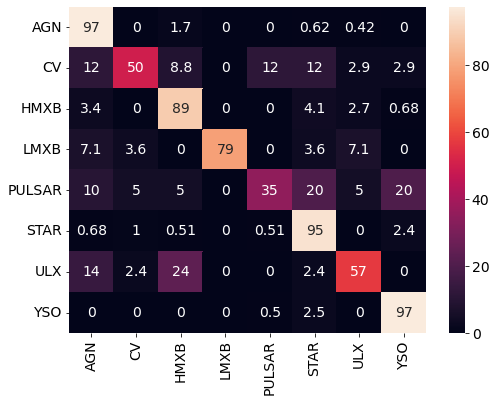

In [157]:
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles , normalize='true')
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(8,6))
l_name = le.inverse_transform(labeles)
sns.heatmap(cnf_matrix*100 , annot=True , xticklabels=l_name , yticklabels=l_name , ax=ax)
plt.show()